Code written by: Billy Atkinson (watkinson@umces.edu) \
Date of last revision: 07/28/2022 \
Reads in numerous satellite data files into one dataframe and outputs the dataframe to nc file \
Also included is quick intro to xarray/pandas syntax through plotting \
Documentation: https://docs.xarray.dev/en/latest/generated/xarray.open_mfdataset.html \
Jupyter notebooks are nice because you can switch between markdown and scripts within the same file

In [26]:
##### we do not need all these packages but these are some of the most important ones I use for your review
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt
import matplotlib.cm as cm
##### cartopy is also really nice, I just have code already written for basemap
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress
import glob
import os

mfdataset basically loops through all files selected (in this case 2004) \
function concatentes file over a selected dimension (in this case time) \
must include combine='nested' because time is not a dimension originally in dataset

In [27]:
dir = '/data/watkinson/Summer2022/data/cafe/1day/' #set directory with files
df = xr.open_mfdataset(dir + 'A2004*.nc',combine='nested',concat_dim='time')
df #prints the dataframe below (366 days because leap year)

<xarray.Dataset>
Dimensions:  (time: 366, lat: 1440, lon: 2112)
Coordinates:
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * lat      (lat) float32 30.99 30.98 30.97 30.96 ... 16.04 16.03 16.02 16.01
  * lon      (lon) float32 -97.99 -97.98 -97.97 -97.96 ... -76.03 -76.02 -76.01
Data variables:
    npp      (time, lat, lon) float64 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
    npp_mld  (time, lat, lon) float64 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
    phyto_c  (time, lat, lon) float64 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
    mu       (time, lat, lon) float64 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
    mu_mld   (time, lat, lon) float64 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
    chlor_a  (time, lat, lon) float32 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
    mld      (time, lat, lon) float64 dask.array<chunksize=(1, 1440, 2112), meta=np.ndarray>
Attributes:
    description:               CAFE model output
    time_coverage_start:       2004-01-01T18:55:01.000Z
    time_coverage_end:         2004-01-01T20:39:59.000Z
    modis_processing_version:  Unspecified
    oc_file:                   L3//media/gsilsbe/SatData/MODISA/V2018.0/Regio...
    cafe_so_file:              pycafe_gom_dena.so

Note about printing ouptut: In python, you usually do: print(df) or print(chlor_a) \
Using xarray/pandas, you can sometimes type just df on seperate line and the output is way cleaner and easier to understand (one of the many benefits of xarray/pandas) \
Not using print() only works at end of code block \
You can compare the two methods when saving chlorophyll to a file

The next two code blocks show you how to output the dataframe to netcdf \
and how to output a single variable from dataframe to netcdf

In [29]:
##### save output dataframe to a nc file in your chosen directory
dir = '/data/watkinson/Summer2022/data/cafe/' #directory you want to save file to
df.to_netcdf(dir + 'Sat_data_2004.nc')

In [30]:
##### save one variable from dataframe to a netcdf
dir = '/data/watkinson/Summer2022/data/cafe/'
sat_data = xr.open_dataset(dir + 'Sat_data_2004.nc')#call in the netcdf file you just created
chlor_a = sat_data.chlor_a
chlor_a.to_netcdf(dir + 'chlor_a_2004.nc')
#chlor_a #just typing variable name gives cleaner view of dataset and is interactive
#print(chlor_a) #this tells you the same thing but not as clear

The code below is an example of reading in a nc file and plotting variables using xarray and matplotlib \
I am going to plot the mean chlorophyll a values for April 2004

Text(0.5, 0, 'Chl (mg * $m^{-3}$)')

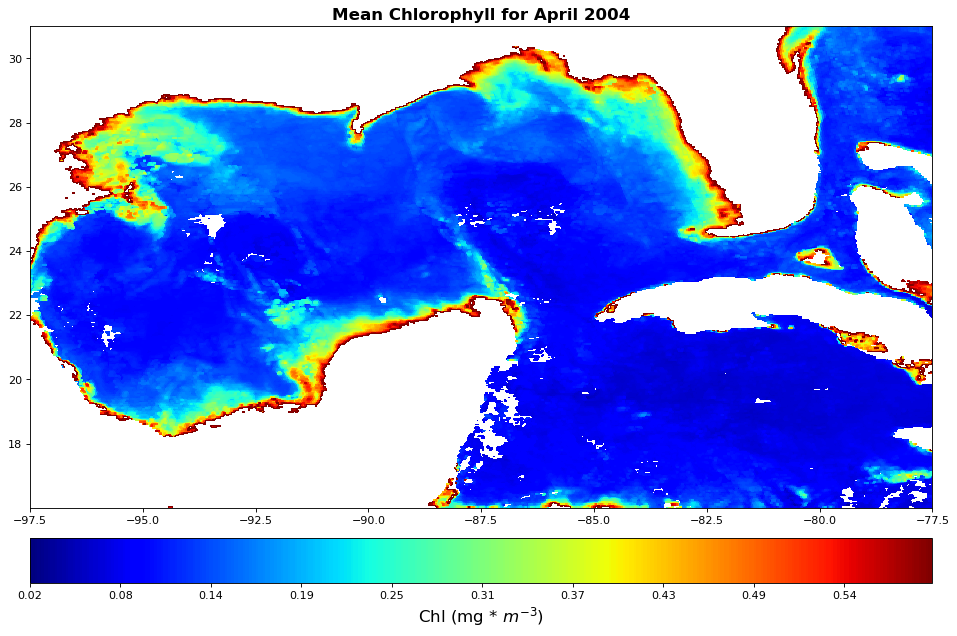

In [31]:
dir = '/data/watkinson/Summer2022/data/cafe/'
sat_data = xr.open_dataset(dir + 'Sat_data_2004.nc')#load in netcdf file

##### select chlorphyll variable
chlor_a = sat_data.chlor_a

##### the timeframe you want for this analysis, two methods to do this: index or datetime
##### could strip away hours, minutes and seconds from datetime array for easier indexing
chlor_april = chlor_a.loc['2004-04-01T00:00:00.000000000':'2004-04-30T00:00:00.000000000']
#chlor_april = chlor_a[91:121]

##### calculate the mean at each lat-lon point for the entire month of april (axis=0=time)
chlor_april_mean = chlor_april.mean(axis=0,skipna=True)#skip NaN values when calculating mean

##### NOTE: I have seperated the steps so the method is clear. However, this can all be done in one line:
#chlor_a = sat_data.chlor_a.loc['2004-04-01T00:00:00.000000000':'2004-04-30T00:00:00.000000000'].mean(axis=0,skipna=True)

#print(chlor_april)
#print(chlor_april_mean)


##### create axes and figure parameters
fig = plt.figure(figsize=(12, 8), dpi=80)
ax = fig.add_axes([.03,.03,.94,.94])
ax.set_xlim(-97.5, -77.5)
plt.title('Mean Chlorophyll for April 2004'
              ,loc='center',fontsize=15,fontweight='bold')

##### load in lat, lon and chlorophyll data for plotting
lat=sat_data.lat
lon=sat_data.lon
z = chlor_april_mean

##### print min, max, and mean chlorophyll values
##### Ive commented out this whole section as an example on how to do that
'''
min_z = np.min(z)
max_z = np.max(z)
mean_z = np.mean(z)
print('Minimum values is:',min_z)
print('Location of Min value:',np.where(z==min_z))
print('Maximum value is:',max_z)
print('Location of Max value:',np.where(z==max_z))
print('Mean value is:',np.mean(z))
'''

##### Make lon and lat a 2d mesh grid for plotting purposes
lon2d,lat2d=np.meshgrid(lon,lat)

##### use contourf(fill contour) and contour(contour lines) to plot
cf = ax.contourf(lon2d,lat2d,z,cmap='jet',levels=np.linspace(.02,.6,400))
#cl = ax.contour(lon2d,lat2d,z,colors='k',alpha=.7,levels=np.arange(.02,1,.1))
plt.clabel(cl, inline=1, fontsize=10)
cbar = fig.colorbar(cf,location='bottom',format='%.2f',pad=.05)#shrink=.6,pad=.04)
cbar.ax.set_xlabel('Chl (mg * $m^{-3}$)',fontsize=15)

##### set save the figure to your directory
#dir = '/data/watkinson/Summer2022/Figures/'
#plt.savefig(dir + 'Chl_Mean_April_2004' + '.png')